# import

In [1]:
import pandas as pd, numpy as np, re, scipy.stats as stats
import seaborn as sns, matplotlib.pyplot as plt, plotly.express as px
from collections import Counter
from tqdm import tqdm


from sklearn import decomposition
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector


import warnings
warnings.filterwarnings('ignore')

# 1. Датасет

In [2]:
%%time
'''
Функция для предварительной обработки датасета:
1) Заполнение пустых значений в поле "Employment.Type"
2) Удаление столбцов с ID
3) Перевод столбцов в датами в формат дат
4) LabelEncoding
'''

df_pr = pd.read_csv('train_LTFS.csv')

def preprocess_df(df):
    print('Start...')
    df['Employment.Type'].fillna('Salaried', inplace=True)
    df.drop_duplicates(inplace=True)
    df.drop(['MobileNo_Avl_Flag', 'PRI.CURRENT.BALANCE'], axis=1, inplace=True)
    
    drops = [col for ind, col in enumerate(df.columns) if re.search('id', col.lower())]
    df.drop(drops, axis=1, inplace=True)

    
    print('Find dates...')
    df['AVERAGE.ACCT.AGE'] = [int(re.findall('[0-9]+', len_hist)[0])*12 + int(re.findall('[0-9]+', len_hist)[1]) 
                              for len_hist in df['AVERAGE.ACCT.AGE']]
    
    df['CREDIT.HISTORY.LENGTH'] = [int(re.findall('[0-9]+', len_hist)[0])*12 + int(re.findall('[0-9]+', len_hist)[1]) 
                              for len_hist in df['CREDIT.HISTORY.LENGTH']]
    
    print('To datetime...')
    df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], errors='coerce').dt.year
    df['Date.of.Birth'] = df['Date.of.Birth'].apply(lambda x: x - 100 if x >= 2005 else x)
    
    df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], errors='coerce')
    df['Disbursal_day'] = df['DisbursalDate'].dt.day
    df['Disbursal_day_week'] = df['DisbursalDate'].dt.dayofweek
    df['Disbursal_month'] = df['DisbursalDate'].dt.month
    df.drop('DisbursalDate', axis=1, inplace=True)
    
    print('Label Encoder...')
    df['Employment.Type'] = LabelEncoder().fit_transform(df['Employment.Type'])
    df['PERFORM_CNS.SCORE.DESCRIPTION'] = LabelEncoder().fit_transform(df['PERFORM_CNS.SCORE.DESCRIPTION'])
    
    df.dropna(axis=0, inplace=True)
    print('End!')
    
    return df

df = preprocess_df(df_pr)
print()

Start...
Find dates...
To datetime...
Label Encoder...
End!

CPU times: total: 15 s
Wall time: 15 s


In [51]:
# Удаляем выбросы с помощью Z-score
df_pr = pd.read_csv('train_LTFS.csv')

z = np.abs(stats.zscore(df))
data_clean = df[(z < 3).all(axis=1)]

print(f'размерность оригинального датасета {df_pr.shape}')
print(f'размерность после предобработки {data_clean.shape}')

data_clean.head()

размерность оригинального датасета (233154, 41)
размерность после предобработки (174993, 33)


,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Disbursal_day,Disbursal_day_week,Disbursal_month
1,47145,65550,73.23,1985,1,1,0,0,0,598,...,0,0,1,23,23,0,1,26,2,9
3,57513,66113,88.48,1993,1,1,0,0,0,305,...,0,0,0,8,15,1,1,26,4,10
4,52378,60300,88.39,1977,1,1,0,0,0,0,...,0,0,0,0,0,1,1,26,2,9
5,54513,61900,89.66,1990,1,1,0,0,0,825,...,0,0,0,21,24,0,0,19,2,9
6,46349,61500,76.42,1988,0,1,0,0,0,0,...,0,0,0,0,0,0,0,23,6,9


In [52]:
%%time

'Определим переменные, которые сильнее всего влияют на loan_default и их оптимальное количество'

y = data_clean.loan_default
x = data_clean.drop('loan_default', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)


log = Pipeline(steps=[('sc', MinMaxScaler()),
                              ('sl', SelectKBest(score_func=f_classif, k=2)),
                              ('model', LogisticRegression())])

log.fit(x_train, y_train)
                       
param_grid = {'sl__k': [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]}     
                
search_log = GridSearchCV(log, 
                             param_grid, 
                             cv=5, 
                             n_jobs=-1, 
                             scoring='roc_auc', 
                             refit=True, 
                             verbose=10)
                
search_log.fit(x_train, y_train)

print()
print(f'Оптимальное количество параметров - {search_log.best_estimator_[1]}')
print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Оптимальное количество параметров - SelectKBest(k=22)

CPU times: total: 3.39 s
Wall time: 16.8 s


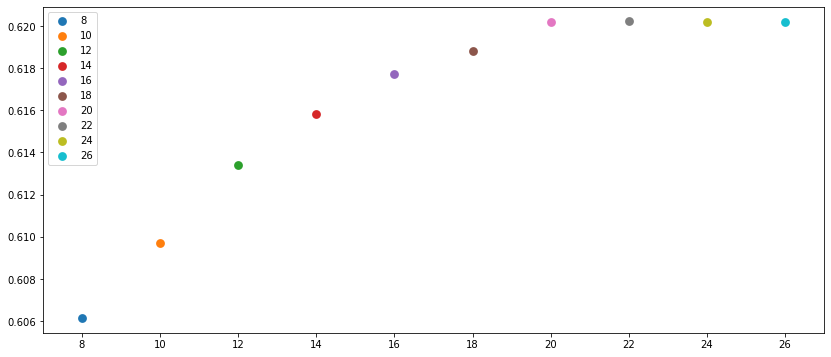

In [53]:
# график точности от количества выбранных факторов
plt.subplots(figsize=(14, 6))

sns.pointplot(x=search_log.cv_results_['param_sl__k'], 
              y=search_log.cv_results_['mean_test_score'],
             hue=search_log.cv_results_['param_sl__k'])
plt.show()

In [54]:
# выбранные колонки (возьмем 20, так как факторов меньше, а точноть та же)
select = SelectKBest(score_func=f_classif, k=20)
best = select.fit_transform(x, y)

columns_imp=x.columns[select.get_support()].to_list()
columns_imp

['disbursed_amount',
 'asset_cost',
 'ltv',
 'Date.of.Birth',
 'Employment.Type',
 'Aadhar_flag',
 'PERFORM_CNS.SCORE',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'PRI.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'PRI.SANCTIONED.AMOUNT',
 'PRI.DISBURSED.AMOUNT',
 'PRIMARY.INSTAL.AMT',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'NO.OF_INQUIRIES',
 'Disbursal_day']

In [55]:
# нормируем данные

for ind, val in enumerate(data_clean[columns_imp]):
    data_clean[val] = np.log1p(data_clean[val])

In [97]:
'''
Также была реализация выделения важных признаков с помощью RandomForestClassifier, 
но SelectKBest показало лучшие результаты
'''

# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# forest_importances = pd.Series(importances, index=x.columns.to_list())
# colors = []
# columns_imp = []
# for ind, imp in enumerate(forest_importances):
#     if imp >=0.04:
#         colors.append('green')
#         columns_imp.append(forest_importances.index[ind])        
#     else: 
#         colors.append('blue')


# fig, ax = plt.subplots(figsize=(15, 8))
# forest_importances.plot.bar(yerr=std, ax=ax, color=colors)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()
print()

# 2. AutoML

In [134]:
# !pip uninstall scikit-learn -y
# !pip uninstall numpy -y
# !pip install scikit-learn==0.23.2
# !pip install numpy==1.20
# !pip install pycaret

# import pycaret
# from pycaret.classification import *
# from pycaret.utils import enable_colab
# enable_colab()

In [135]:
# import h2o
# from h2o.automl import H2OAutoML

Воспользуемся библиотекой LightAutoML для нахождения предварительной оценки по моделям.
В данном случае, не используется библиотека PyCaret, которая была в прошлый раз, так как не показывает высокую производительность на больших датасетах

In [197]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [266]:
# Считывание датасета, небольшая очистка, удаление столбцов с id
df_auto = pd.read_csv('train_LTFS.csv')

df_auto.drop(['MobileNo_Avl_Flag', 'PRI.CURRENT.BALANCE'], axis=1, inplace=True)
ids = [col for ind, col in enumerate(df_auto.columns) if re.search('id', col.lower())]
df_auto.drop(ids, axis=1, inplace=True)
df_auto.drop_duplicates(inplace=True)
df_auto.dropna(axis=0, inplace=True)

print(('df shape - {}'.format(df_auto.shape)))


xx = df_auto.drop('loan_default', axis=1)
yy = df_auto.loan_default

x_train, x_test, y_train, y_test = train_test_split(xx, yy,
                                                    stratify=yy, test_size=0.25)

x_train['loan_default'] = y_train
x_train.shape, y_train.shape, x_test.shape, y_test.shape

df shape - (225491, 31)


((169118, 31), (169118,), (56373, 30), (56373,))

In [268]:
roles = {
    'target': 'loan_default',
}

automl = TabularAutoML(
    task=Task('binary'),
    timeout=60*3,
    reader_params={'n_jobs': 6, 'cv': 5, 'random_state': 101}
)

rd = ReportDeco('TabReport2')
automl_rd = rd(automl)

models = automl_rd.fit_predict(x_train, roles=roles, verbose=1)

[19:23:15] Stdout logging level is INFO.
[19:23:15] Task: binary

[19:23:15] Start automl preset with listed constraints:
[19:23:15] - time: 300.00 seconds
[19:23:15] - CPU: 4 cores
[19:23:15] - memory: 16 GB

[19:23:15] Train data shape: (169118, 31)

[19:23:45] Layer 1 train process start. Time left 269.75 secs
[19:23:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:24:05] Time limit exceeded after calculating fold 3

[19:24:05] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6354292131323951
[19:24:05] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:24:05] Time left 250.11 secs

[19:24:08] Selector_LightGBM fitting and predicting completed
[19:24:15] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:24:34] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.6461388644488824
[19:24:34] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:24:34] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.0

<AxesSubplot:xlabel='Feature'>

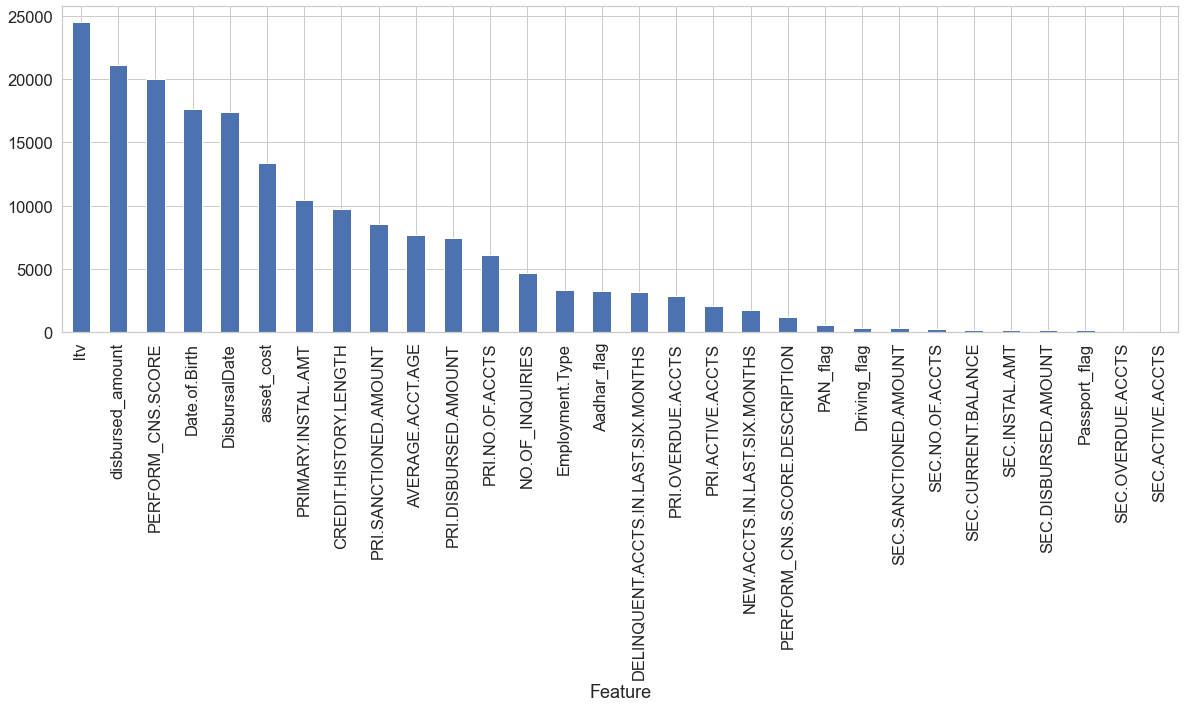

In [269]:
imps = automl_rd.model.get_feature_scores('fast')
imps.set_index('Feature')['Importance'].plot.bar(figsize=(20, 6))

In [270]:
imps.head(10)

,Feature,Importance
0,ltv,24514.055717
1,disbursed_amount,21066.907694
2,PERFORM_CNS.SCORE,20027.043957
3,Date.of.Birth,17636.558281
4,DisbursalDate,17380.054537
5,asset_cost,13405.197592
6,PRIMARY.INSTAL.AMT,10461.719209
7,CREDIT.HISTORY.LENGTH,9730.959504
8,PRI.SANCTIONED.AMOUNT,8524.043059
9,AVERAGE.ACCT.AGE,7671.993707


In [275]:
preds = automl.predict(x_test)

print(f'AUC score on train: {roc_auc_score(y_train.values, models.data[:, 0])}')
print(f'GINI score on train: {roc_auc_score(y_train.values, models.data[:, 0])*2-1}')
print()
print(f'AUC score on test: {roc_auc_score(y_test.values, preds.data[:, 0])}')
print(f'GINI score on test: {roc_auc_score(y_test.values, preds.data[:, 0])*2-1}')

AUC score on train: 0.6493588664101343
GINI score on train: 0.2987177328202686

AUC score on test: 0.6503250553387429
GINI score on test: 0.3006501106774857


Final prediction for new objects (level 0) =

>	 0.19636 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
>	 0.10541 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
>	 0.31304 * (3 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
>	 0.38519 * (4 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost)

Так выглядит финальная модель (несколько моделей с весами).

**AUC на тестовой выборке состовляет 0.65**

# 3. Модели

In [57]:
# функция для оценки моделей
def get_report(pipe, x_test, y_test, pipe_grid=None, grid=False):
    
    predictions = pipe.predict(x_test)
    predictions = np.round(predictions.ravel(), 0)

    roc_auc_scores_pipe = roc_auc_score(y_test, pipe.predict_proba(x_test)[:, 1])
    gini = (2 * roc_auc_scores_pipe) - 1
    
    print('y_test - ', Counter(y_test))
    print('predictions - ', Counter(predictions))
    print()
    print(f'roc_auc_score - {round(roc_auc_scores_pipe, 4)}')
    print('Gini - ', round(gini, 4))
    
    if grid:
        roc_auc_scores_grid = roc_auc_score(y_test, pipe_grid.predict_proba(x_test)[:, 1])
        print(f'grid - pipe: {round(roc_auc_scores_grid - roc_auc_scores_pipe, 5)}')
        gini2 = (2 * roc_auc_scores_grid) - 1 - gini
        print('Gini with grid - ', round(gini2, 4))

    print()
    print((classification_report(y_test, predictions)))

In [58]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks

In [59]:
%%time

# исправляем дисбаланс классов с помощью создания дополнительных данных
# и выбранных признаков

data_clean=data_clean[columns_imp+['loan_default']]

y = data_clean.loan_default
x = data_clean.drop('loan_default', axis=1)

imbalance = SMOTETomek(sampling_strategy='minority', n_jobs=6)
x_imb, y_imb = imbalance.fit_resample(x, y)

x_imb.shape, y_imb.shape

CPU times: total: 6min 24s
Wall time: 1min 16s


((261186, 20), (261186,))

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, test_size=0.25)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((195889, 20), (195889,), (65297, 20), (65297,))

## LogisticRegression

In [66]:
pipe_logreg = Pipeline(steps=[('sc', MinMaxScaler()), 
                       ('model', LogisticRegression(max_iter=1000, C=120, solver='lbfgs', tol=0.5))])

pipe_logreg.fit(x_train, y_train)

get_report(pipe=pipe_logreg, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({1: 32649, 0: 32648})
predictions -  Counter({1: 36780, 0: 28517})

roc_auc_score - 0.6254
Gini -  0.2507

              precision    recall  f1-score   support

           0       0.60      0.53      0.56     32648
           1       0.58      0.65      0.61     32649

    accuracy                           0.59     65297
   macro avg       0.59      0.59      0.59     65297
weighted avg       0.59      0.59      0.59     65297




In [18]:
cv_pipe_logreg = cross_val_predict(pipe_logreg,
                                   cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
                                   X=x_train,
                                   y=y_train,
                                   verbose=1,
                                   n_jobs=-1,
                                   method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    5.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    6.3s finished


In [19]:
print(f'auc score = {roc_auc_score(y_train, cv_pipe_logreg[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_pipe_logreg[:, 1])) - 1 :.5f}')

auc score = 0.62473
Gini      = 0.24947


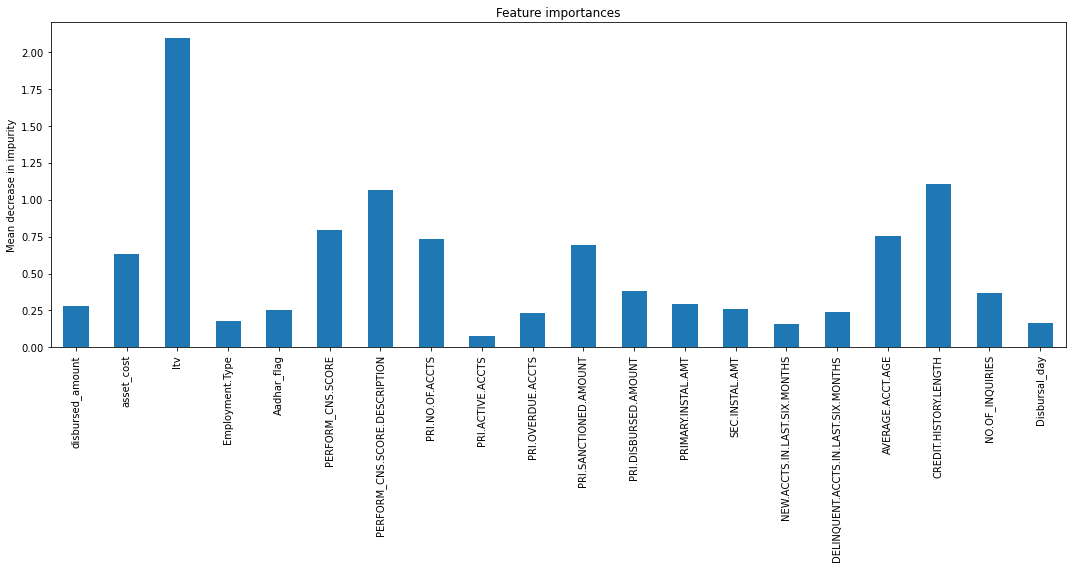

In [20]:
log_importances = pd.Series(abs(pipe_logreg[-1].coef_[0]), index=x_train.columns)

fig, ax = plt.subplots(figsize=(15,8))
log_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [21]:
pd.DataFrame(list(zip(pipe_logreg[-1].coef_[0], x.columns)), columns=['importance', 'features']) \
                                                    .set_index('features') \
                                                    .sort_values(by='importance', ascending=False)

,importance
features,
ltv,2.094308
PERFORM_CNS.SCORE.DESCRIPTION,1.063900
PERFORM_CNS.SCORE,0.797779
AVERAGE.ACCT.AGE,0.751312
asset_cost,0.631572
PRI.DISBURSED.AMOUNT,0.383934
NO.OF_INQUIRIES,0.366216
PRIMARY.INSTAL.AMT,0.292590
disbursed_amount,0.277840


In [ ]:
# Модель плохо работает, не получилось достигнуть хорошего результата.
# также, результат ниже, чем у AutoML

## LinearRegression

In [67]:
pipe_linreg = Pipeline(steps=[('scaler', MinMaxScaler()), 
                       ('logistic', LinearRegression(positive=True, fit_intercept=True))])

pipe_linreg.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LinearRegression(positive=True))])

In [24]:
predictions = pipe_linreg.predict(x_test)
diff = predictions - y_test

print('MSE:', np.mean(diff**2))
print('MAE:', np.mean(abs(diff)))
print('RMSE:', np.sqrt(np.mean(diff**2)))
print()
print(classification_report(y_test, np.round(predictions.ravel(), 0)))

MSE: 0.23990816430572898
MAE: 0.47971302035050517
RMSE: 0.48980421017558534

              precision    recall  f1-score   support

           0       0.60      0.51      0.55     32345
           1       0.57      0.66      0.61     32344

    accuracy                           0.58     64689
   macro avg       0.59      0.58      0.58     64689
weighted avg       0.59      0.58      0.58     64689



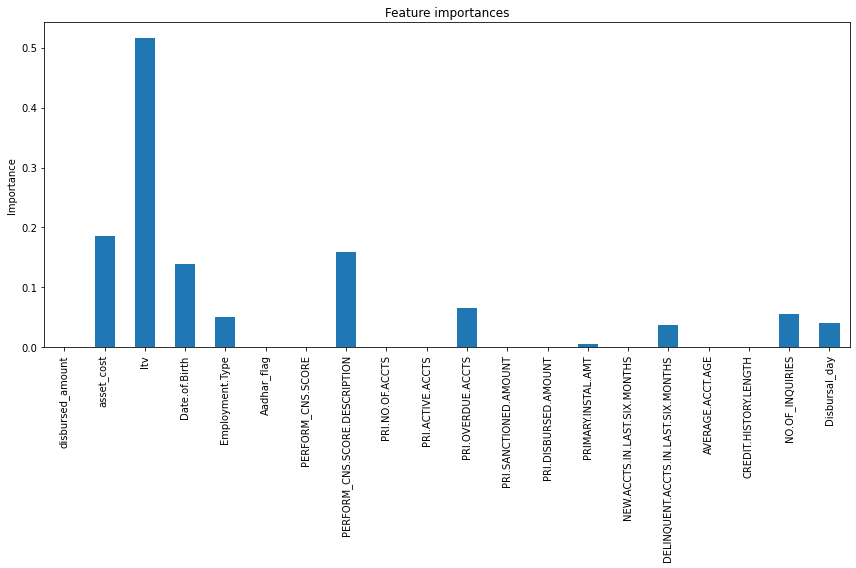

In [77]:
log_importances = pd.Series(abs(pipe_linreg[-1].coef_), index=x_train.columns)

fig, ax = plt.subplots(figsize=(12, 8))
log_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Importance')
fig.tight_layout()

In [25]:
pd.DataFrame(list(zip(pipe_linreg[-1].coef_, x.columns)), columns=['importance', 'features']) \
                                                    .set_index('features') \
                                                    .sort_values(by='importance', ascending=False)

,importance
features,
ltv,0.512150
asset_cost,0.205376
PERFORM_CNS.SCORE.DESCRIPTION,0.178518
NO.OF_INQUIRIES,0.065339
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,0.047826
PRI.OVERDUE.ACCTS,0.047677
Employment.Type,0.044343
SEC.INSTAL.AMT,0.039554
Disbursal_day,0.038900


In [ ]:
# Аналогично LinearRegression - плохой результат

## RandomForestClassifier

In [61]:
pipe_rforest = Pipeline(steps=[
    ('sc', MinMaxScaler()), 
    ('m', RandomForestClassifier(verbose=1, 
                                 n_jobs=-1,
                                 criterion='gini',
                                 n_estimators=100))
])

pipe_rforest.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


Pipeline(steps=[('sc', MinMaxScaler()),
                ('m', RandomForestClassifier(n_jobs=-1, verbose=1))])

In [62]:
get_report(pipe=pipe_rforest, x_test=x_test, y_test=y_test)
print()

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


y_test -  Counter({1: 32649, 0: 32648})
predictions -  Counter({0: 33755, 1: 31542})

roc_auc_score - 0.9077
Gini -  0.8154

              precision    recall  f1-score   support

           0       0.82      0.85      0.84     32648
           1       0.84      0.82      0.83     32649

    accuracy                           0.83     65297
   macro avg       0.83      0.83      0.83     65297
weighted avg       0.83      0.83      0.83     65297




[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.5s finished


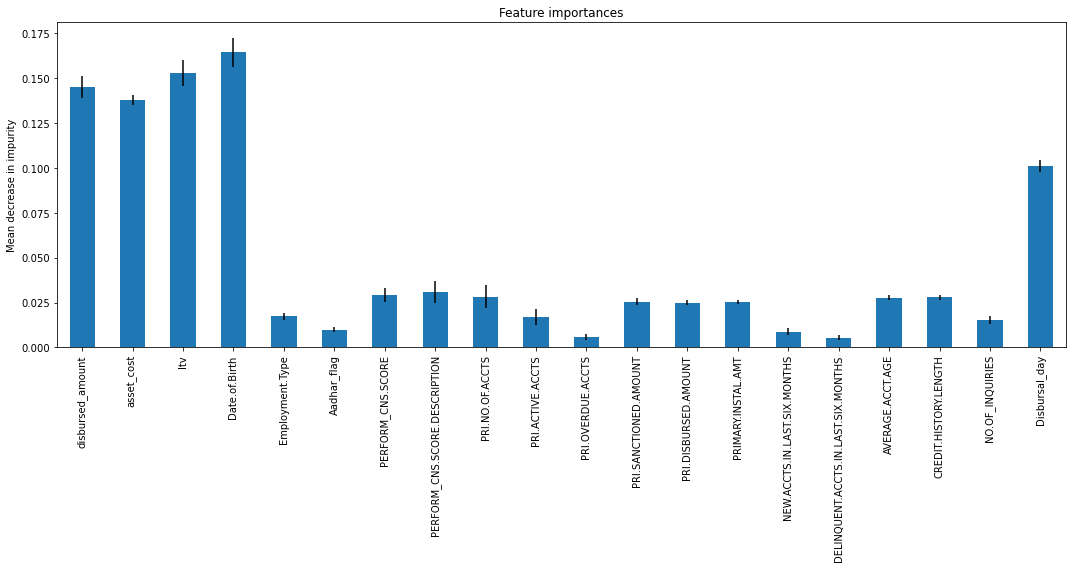

In [63]:
importances = pipe_rforest[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe_rforest[-1].estimators_], axis=0)

forest_importances = pd.Series(importances, index=x_train.columns)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [64]:
%%time
cv_pipe_rforest = cross_val_predict(pipe_rforest,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   56.4s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   56.5s remaining:   37.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.6s finished


CPU times: total: 93.8 ms
Wall time: 57 s


In [65]:
print(f'auc score = {roc_auc_score(y_train, cv_pipe_rforest[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_pipe_rforest[:, 1]) - 1) :.5f}')

auc score = 0.89395
Gini      = 0.78790


In [ ]:
# модель RandomForestClassifier показала высокие результаты по AUC - 0.9
# также, быда проверка через кросс-валидацию, AUC чуть ниже и состовляет 0.894


# y_test -  Counter({1: 32649, 0: 32648}) - количество дефолтов в y_test
# predictions -  Counter({0: 33755, 1: 31542}) - количество дефолтов в предсказаниях модели

## LGBMClassifier

In [68]:
pipe_lgbm_cls = Pipeline(steps=[('sc', MinMaxScaler()), 
                                ('model', LGBMClassifier(boosting_type='gbdt',
                                                         objective='binary' ,
                                                         n_estimators=1500,
                                                         max_depth=-1,
                                                         learning_rate=0.95,
                                                         num_leaves=90,
                                                         importance_type='gain'))])

pipe_lgbm_cls.fit(x_train, y_train)

Pipeline(steps=[('sc', MinMaxScaler()),
                ('model',
                 LGBMClassifier(importance_type='gain', learning_rate=0.95,
                                n_estimators=1500, num_leaves=90,
                                objective='binary'))])

In [69]:
get_report(pipe=pipe_lgbm_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({1: 32649, 0: 32648})
predictions -  Counter({0: 35814, 1: 29483})

roc_auc_score - 0.8839
Gini -  0.7677

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     32648
           1       0.86      0.77      0.81     32649

    accuracy                           0.82     65297
   macro avg       0.83      0.82      0.82     65297
weighted avg       0.83      0.82      0.82     65297




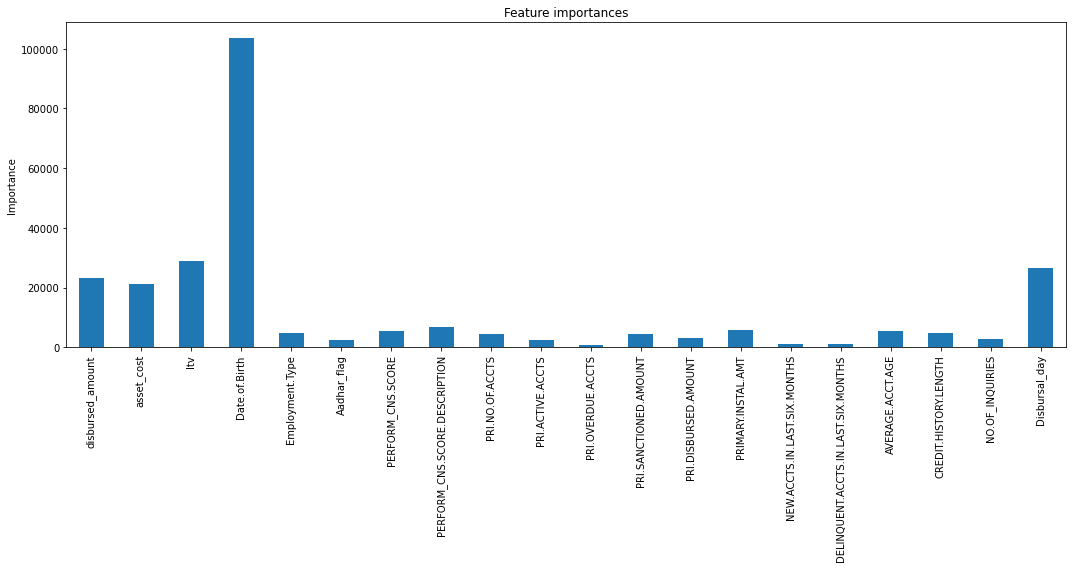

In [78]:
importances = pipe_lgbm_cls[-1].feature_importances_

forest_importances = pd.Series(importances, index=x_train.columns)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Importance')
fig.tight_layout()

In [70]:
pd.DataFrame(data=MinMaxScaler().fit_transform(pipe_lgbm_cls[-1].feature_importances_.reshape(-1, 1)), 
             index=x_imb.columns) \
             .sort_values(by=0, ascending=False)

,0
Date.of.Birth,1.000000
ltv,0.274655
Disbursal_day,0.251413
disbursed_amount,0.219502
asset_cost,0.199657
PERFORM_CNS.SCORE.DESCRIPTION,0.058019
PRIMARY.INSTAL.AMT,0.047655
PERFORM_CNS.SCORE,0.046357
AVERAGE.ACCT.AGE,0.044753
Employment.Type,0.039140


In [71]:
%%time
cv_lgbm_cls = cross_val_predict(pipe_lgbm_cls,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.1s remaining:   49.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   33.7s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.1s finished


CPU times: total: 93.8 ms
Wall time: 35.5 s


In [72]:
print(f'auc score = {roc_auc_score(y_train, cv_lgbm_cls[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_lgbm_cls[:, 1]) - 1) :.5f}')

auc score = 0.88456
Gini      = 0.76913


In [ ]:
# Аналогично RandomForestClassifier, показывает высокие результаты, но хуже на 0.02
# выигрывает по скорости работы у RandomForestClassifier

## XGBClassifier

In [73]:
pipe_xgb_cls = Pipeline(steps=[('scaler', MinMaxScaler()), 
                               ('model', XGBClassifier(tree_method='gpu_hist',
                                                       objective='binary:logistic',
                                                       learning_rate=0.5,
                                                       n_estimators=50,
                                                       reg_lambda=25,
                                                       max_depth=30))])

pipe_xgb_cls.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=30, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [74]:
get_report(pipe=pipe_xgb_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({1: 32649, 0: 32648})
predictions -  Counter({0: 38176, 1: 27121})

roc_auc_score - 0.8935
Gini -  0.787

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     32648
           1       0.89      0.74      0.81     32649

    accuracy                           0.83     65297
   macro avg       0.84      0.83      0.83     65297
weighted avg       0.84      0.83      0.83     65297




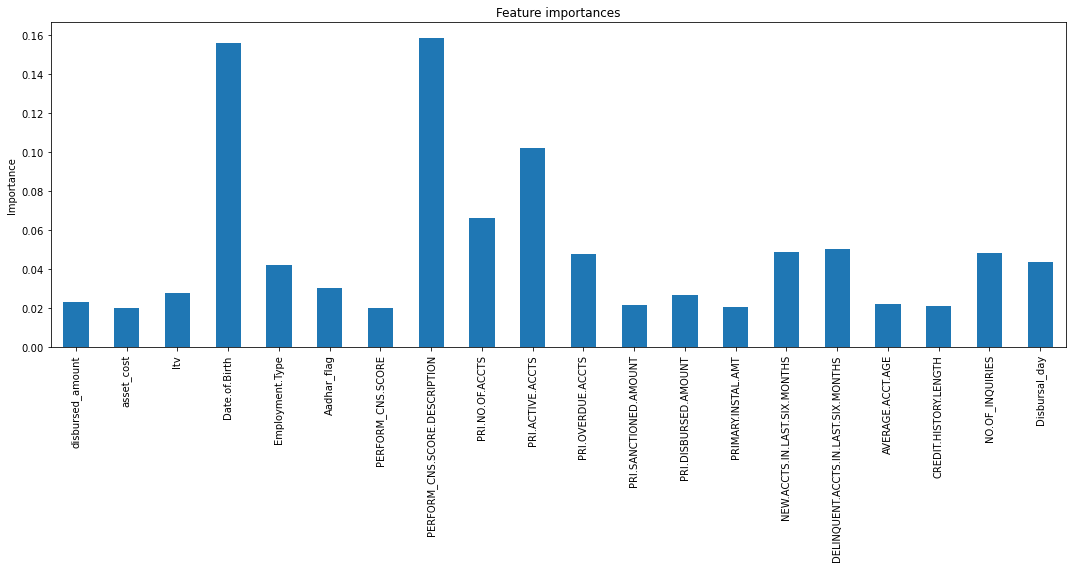

In [79]:
importances = pipe_xgb_cls[-1].feature_importances_

forest_importances = pd.Series(importances, index=x_train.columns)

fig, ax = plt.subplots(figsize=(15,8))
forest_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Importance')
fig.tight_layout()

In [75]:
pd.DataFrame(data=MinMaxScaler().fit_transform(pipe_xgb_cls[-1].feature_importances_.reshape(-1, 1)), 
             index=x_imb.columns) \
             .sort_values(by=0, ascending=False)

,0
PERFORM_CNS.SCORE.DESCRIPTION,1.000000
Date.of.Birth,0.981329
PRI.ACTIVE.ACCTS,0.592052
PRI.NO.OF.ACCTS,0.332913
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,0.216723
NEW.ACCTS.IN.LAST.SIX.MONTHS,0.208352
NO.OF_INQUIRIES,0.204769
PRI.OVERDUE.ACCTS,0.200343
Disbursal_day,0.169366
Employment.Type,0.158940


In [71]:
%%time
cv_xgb_cls = cross_val_predict(pipe_xgb_cls,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True),
                                    X=x_train,
                                    y=y_train,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.4s remaining:   54.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   36.7s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished


CPU times: total: 109 ms
Wall time: 39.2 s


In [192]:
print(f'auc score = {roc_auc_score(y_train, cv_xgb_cls[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_train, cv_xgb_cls[:, 1]) - 1) :.5f}')

auc score = 0.89322
Gini      = 0.78644


In [ ]:
# Аналогично RandomForestClassifier и LGBMClassifier, скорость средняя, 
# результат лучше, чем у LGBMClassifier

# в целом, модели по качеству схожи

## CatBoost

In [80]:
from catboost import CatBoostClassifier, cv, Pool, MetricVisualizer
from catboost.utils import select_threshold, get_roc_curve, get_fpr_curve, get_fnr_curve
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures

In [81]:
x_train_cat = MinMaxScaler().fit_transform(x_train)
x_test_cat = MinMaxScaler().fit_transform(x_test)

In [82]:
model_catboost_cls = CatBoostClassifier(
    loss_function='Logloss', custom_loss='AUC', #eval_metric='AUC',
    learning_rate=0.01, iterations=5000,
#     l2_leaf_reg=7, random_strength=10, bagging_temperature=7
    l2_leaf_reg=10, random_strength=101, bagging_temperature=5, depth=8,
)

m = model_catboost_cls.fit(x_train_cat, y_train, eval_set=(x_test_cat, y_test),
                       verbose=500, plot=True, early_stopping_rounds=200)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6929963	test: 0.6930131	best: 0.6930131 (0)	total: 192ms	remaining: 15m 57s
500:	learn: 0.6383780	test: 0.6413520	best: 0.6413520 (500)	total: 16.7s	remaining: 2m 29s
1000:	learn: 0.6183370	test: 0.6234661	best: 0.6234661 (1000)	total: 32.1s	remaining: 2m 8s
1500:	learn: 0.5830134	test: 0.5901532	best: 0.5901532 (1500)	total: 48.7s	remaining: 1m 53s
2000:	learn: 0.3967217	test: 0.4030734	best: 0.4030734 (2000)	total: 1m 5s	remaining: 1m 38s
2500:	learn: 0.3516094	test: 0.3583966	best: 0.3583966 (2500)	total: 1m 23s	remaining: 1m 23s
3000:	learn: 0.3400763	test: 0.3489737	best: 0.3489737 (3000)	total: 1m 40s	remaining: 1m 6s
3500:	learn: 0.3338381	test: 0.3453047	best: 0.3453047 (3500)	total: 1m 58s	remaining: 50.8s
4000:	learn: 0.3276839	test: 0.3415164	best: 0.3415164 (4000)	total: 2m 16s	remaining: 34s
4500:	learn: 0.3235861	test: 0.3399716	best: 0.3399680 (4493)	total: 2m 34s	remaining: 17.1s
4999:	learn: 0.3203048	test: 0.3394098	best: 0.3394098 (4999)	total: 2m 52s	rem

In [84]:
print(f'auc score = {roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]) - 1) :.5f}')

auc score = 0.89948
Gini      = 0.79896


<AxesSubplot:>

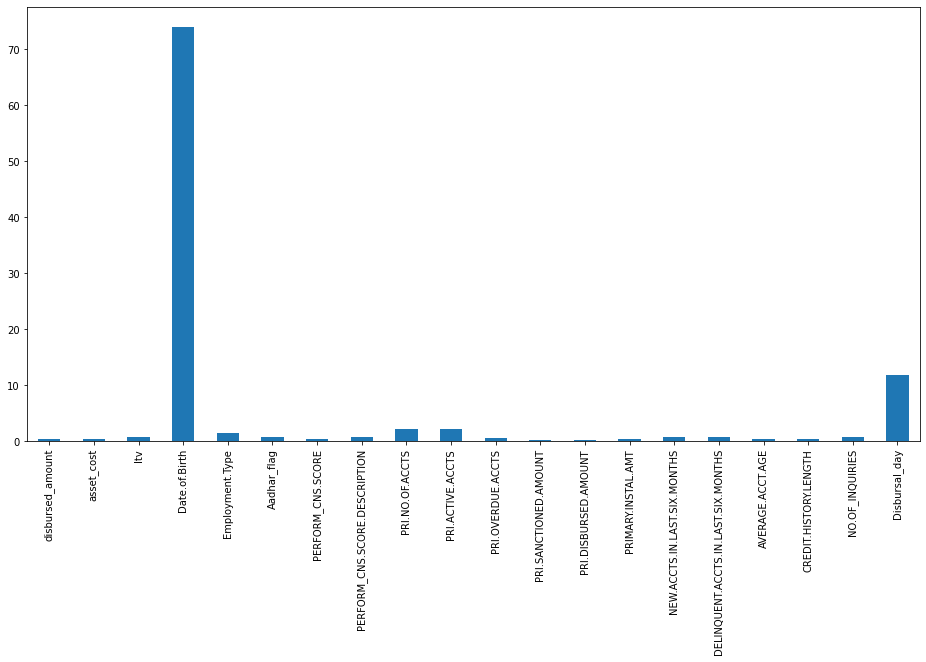

In [129]:
cat_features = pd.DataFrame(model_catboost_cls.get_feature_importance(prettified=True))
cat_features['Feature Id'] = (cat_features['Feature Id']).astype('int')
cat_features=cat_features.sort_values(by='Feature Id')

skl_iris_imp = pd.Series(cat_features.Importances.values,
                         x_train.columns)

fig, ax = plt.subplots(figsize=(16, 8))
skl_iris_imp.plot.bar(ax=ax)

In [130]:
cat_features = pd.DataFrame(model_catboost_cls.get_feature_importance(prettified=True))
cat_features['Feature Id'] = (cat_features['Feature Id']).astype('int')
cat_features=cat_features.sort_values(by='Feature Id')

cat_features

,Feature Id,Importances
12,0,0.506086
15,1,0.386396
10,2,0.709002
0,3,73.859945
4,4,1.545067
7,5,0.812569
14,6,0.412574
8,7,0.737487
2,8,2.238504
3,9,2.191411


График потерь

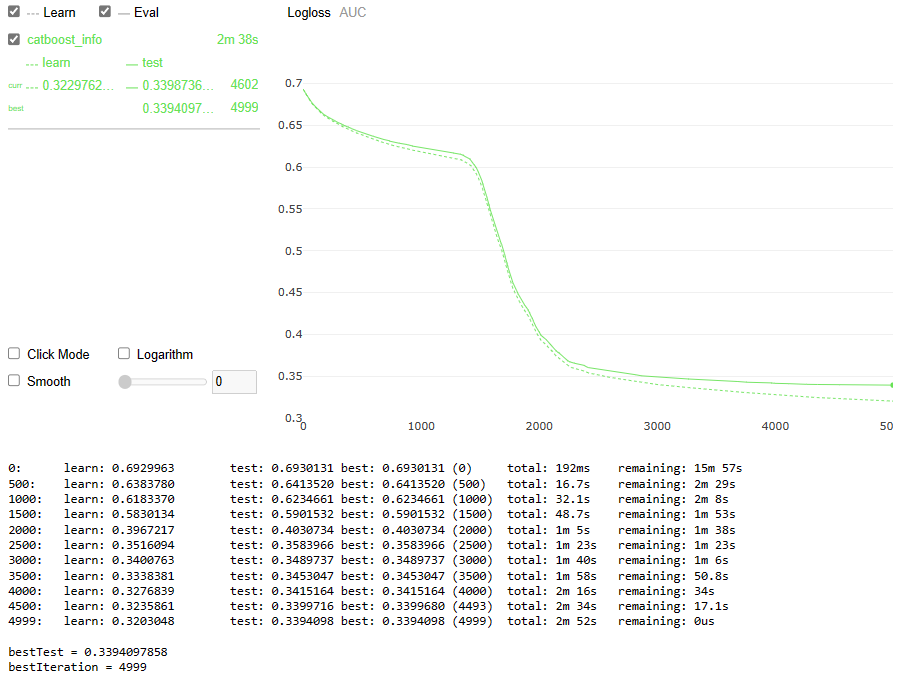

график AUC
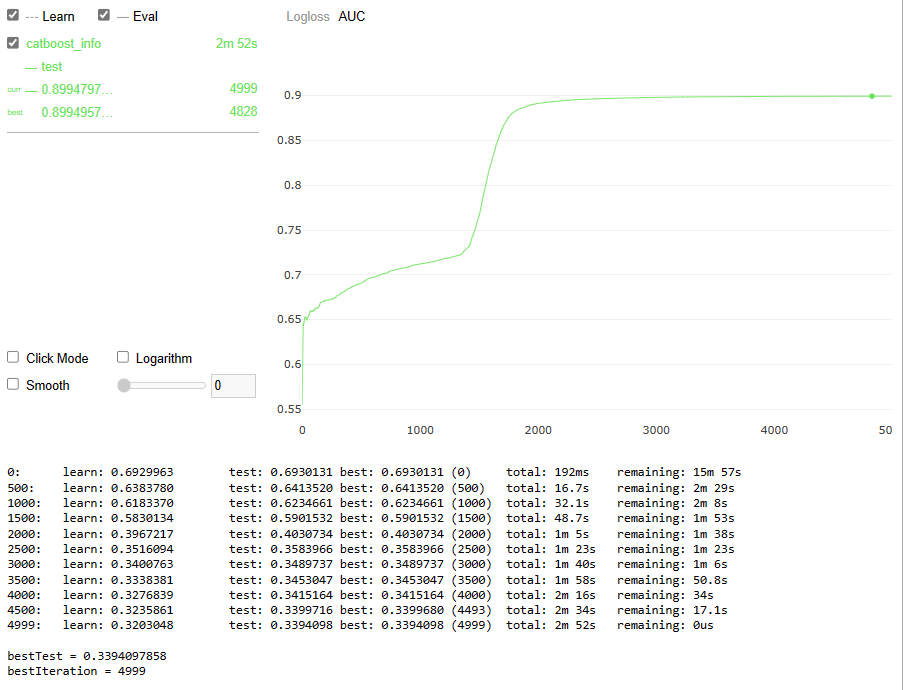

In [84]:
print(f'auc score = {roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]) - 1) :.5f}')

auc score = 0.89948
Gini      = 0.79896


In [ ]:
# модель, как и остальные бустинги, показывает хорошее качетсво
# но графики потерь и AUC не совсем "красивые"

# это связано с тем, что качетсво не падало ниже 0.65 (LogLoss) и пришлось менять L2 и глубину деревьев.
# сделать LogLoss ниже 0.35 не удалось

## NN

In [ ]:
# для обучения нейронной сети выбрал другое количество колонок
# эти колонки чаще всего были в feature importance

columns_imp=['disbursed_amount',
 'asset_cost',
 'ltv',
 'PERFORM_CNS.SCORE',
 'PERFORM_CNS.SCORE.DESCRIPTION',
 'Disbursal_day_week']

# нормируем данные
for ind, val in enumerate(data_clean[columns_imp]):
    data_clean[val] = np.log1p(data_clean[val])

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks

data_clean=data_clean[columns_imp+['loan_default']]

y = data_clean.loan_default
x = data_clean.drop('loan_default', axis=1)

In [68]:
%%time

imbalance = SMOTETomek(sampling_strategy='minority', n_jobs=-1) # исправляем дисбаланс
x_imb, y_imb = imbalance.fit_resample(x, y)

x_imb.shape, y_imb.shape

CPU times: user 9.75 s, sys: 17.4 ms, total: 9.77 s
Wall time: 7.91 s


((250112, 6), (250112,))

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, test_size=0.2)

x_train_sc = MinMaxScaler().fit_transform(x_train)
x_test_sc = MinMaxScaler().fit_transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((200089, 6), (200089,), (50023, 6), (50023,))

In [ ]:
model = Sequential()

model.add(Dense(units = 300, input_shape = (x_train_sc.shape[1],), activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

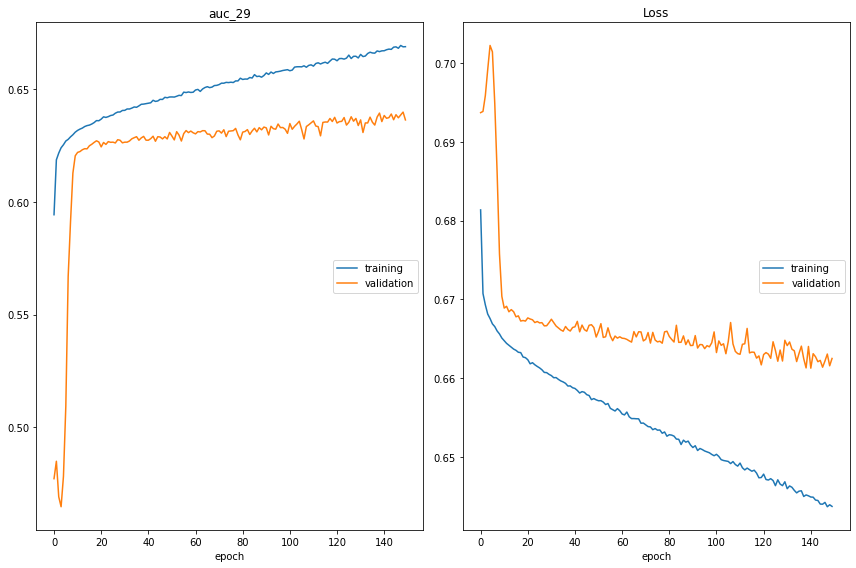

auc_29
	training         	 (min:    0.594, max:    0.669, cur:    0.669)
	validation       	 (min:    0.465, max:    0.640, cur:    0.636)
Loss
	training         	 (min:    0.644, max:    0.681, cur:    0.644)
	validation       	 (min:    0.661, max:    0.702, cur:    0.662)
74/74 [==============================] - 1s 14ms/step - loss: 0.6437 - auc_29: 0.6689 - val_loss: 0.6625 - val_auc_29: 0.6364



In [87]:
cp = ModelCheckpoint('model/', save_best_only=True)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.0008, nesterov=True), 
# metrics=[keras.metrics.AUC()])

model.compile(loss=keras.losses.BinaryCrossentropy(), 
              optimizer=keras.optimizers.Adam(learning_rate=0.00005), 
              metrics=[keras.metrics.AUC()]
              )

history = model.fit(x_train_sc, 
                    y_train, 
                    validation_split=0.25, 
                    batch_size=2048, 
                    epochs=150, 
                    verbose=1,
                    callbacks=[cp, 
                               PlotLossesKeras(), 
                               callback])
                                 

print('\n ==============')

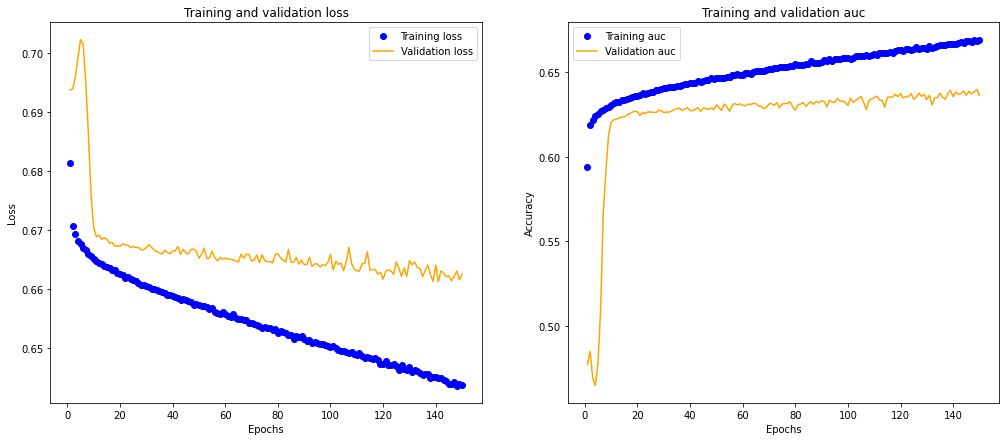


Best auc score: 0.6399089694023132


In [88]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1) 

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc = history.history[list(history.history.keys())[1]]
val_acc = history.history[list(history.history.keys())[3]]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'orange', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print()
print(f'Best auc score: {np.max(val_acc)}')

plt.show()

In [89]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, auc, roc_curve

model = load_model('model/')

predictions = model.predict(x_test_sc, batch_size=128)
predictions = np.round(predictions.ravel(), 0)

print()
print('auc(fpr, tpr)', auc(roc_curve(y_test, predictions)[0], roc_curve(y_test, predictions)[1]))
print()
print(classification_report(y_test, predictions))
print()
print('test loss, test acc:', model.evaluate(x_test_sc, y_test, batch_size=256))

391/391 [==============================] - 3s 6ms/step

auc(fpr, tpr) 0.5920484903482385

              precision    recall  f1-score   support

           0       0.60      0.55      0.57     25012
           1       0.58      0.63      0.61     25011

    accuracy                           0.59     50023
   macro avg       0.59      0.59      0.59     50023
weighted avg       0.59      0.59      0.59     50023


196/196 [==============================] - 1s 4ms/step - loss: 0.6674 - auc_29: 0.6253
test loss, test acc: [0.6674125790596008, 0.6252862215042114]


In [ ]:
# результаты получились плохие, аналогично CatBoost лосс не падает ниже 0.65 или падал медленно

# так как x_train имеет размерность в 200_000 строк, то можно было увеличить мини батчи, но с ними пришлось
# уменьшать и скорость обучения

# смотря на графики обучения, можно сказать, что NN с такой архитиктурой не улавливает взаимосвязей
# и не обобщает - валид-выборка идет "пилой". Кроме того, AUC на обучающей выборке тоже сильно не меняется (концентрация
# точек на графике высокая)

# увеличение количества слоев и количества нейронов не привело к улучшению результата

# Результаты

In [131]:
da = [['LogisticRegression',
       roc_auc_score(y_test, pipe_logreg.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_logreg.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_logreg.predict(x_test), 0), average='weighted')[2]],
      
      ['LinearRegression',
       0,
       0,
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_linreg.predict(x_test), 0), average='weighted')[2]],
      
      ['RandomForestClassifier',
       roc_auc_score(y_test, pipe_rforest.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_rforest.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_rforest.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_rforest.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_rforest.predict(x_test), 0), average='weighted')[2]],
      
      ['LGBMClassifier',
       roc_auc_score(y_test, pipe_lgbm_cls.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_lgbm_cls.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_lgbm_cls.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_lgbm_cls.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_lgbm_cls.predict(x_test), 0), average='weighted')[2]],
      
      ['XGBClassifier',
       roc_auc_score(y_test, pipe_xgb_cls.predict_proba(x_test)[:, 1]),
       2 * roc_auc_score(y_test, pipe_xgb_cls.predict_proba(x_test)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(pipe_xgb_cls.predict(x_test), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(pipe_xgb_cls.predict(x_test), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(pipe_xgb_cls.predict(x_test), 0), average='weighted')[2]],
 
      ['CatBoostClassifier',
       roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1]),
       2 * roc_auc_score(y_test, model_catboost_cls.predict_proba(x_test_cat)[:, 1])-1,
       precision_recall_fscore_support(y_test, np.round(model_catboost_cls.predict(x_test_cat), 0), average='weighted')[0],
       precision_recall_fscore_support(y_test, np.round(model_catboost_cls.predict(x_test_cat), 0), average='weighted')[1],
       precision_recall_fscore_support(y_test, np.round(model_catboost_cls.predict(x_test_cat), 0), average='weighted')[2]],

      ['NN',
       0.6252862215042114,
       2 * 0.6252862215042114 - 1,
       0.59,
       0.59,
       0.59]
      
     ]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_job

In [132]:
result = pd.DataFrame(da, columns=['Model', 'AUC', 'GINI', 'PRECISION', 'RECALL', 'FSCORE']).set_index('Model')

result.sort_values(by='GINI', ascending=False)\
.style.background_gradient(cmap=sns.light_palette('darkblue', as_cmap=True), vmin=0.762)

,AUC,GINI,PRECISION,RECALL,FSCORE
Model,,,,,
RandomForestClassifier,0.907701,0.815403,0.832856,0.832473,0.832425
CatBoostClassifier,0.899480,0.798960,0.883804,0.852413,0.849332
XGBClassifier,0.893489,0.786978,0.837509,0.827833,0.826590
LGBMClassifier,0.883871,0.767743,0.825070,0.822013,0.821594
LogisticRegression,0.625359,0.250718,0.591569,0.590104,0.588456
NN,0.625286,0.250572,0.590000,0.590000,0.590000
LinearRegression,0.000000,0.000000,0.583907,0.582278,0.580239


Лучше всего показала себя модель **RandomForestClassifier**, но остальные бустинги примерно схожи 

>    LGBMClassifier выигрывает в скорости

>    XGBClassifier - почти такой же результат, как RandomForestClassifier, но чуть быстрее

NN - не обучилась нормально, как и LogisticRegression и LinearRegression